In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [10]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#same mass in all cases
fwd_cg_pld = C172.PayloadU(m_pilot = 100, m_copilot = 100, m_baggage = 0)
aft_cg_pld = C172.PayloadU(m_pilot = 50, m_copilot = 50, m_baggage = 100)
mid_cg_pld = C172.PayloadU(m_pilot = 75, m_copilot = 75, m_baggage = 50)

design_condition = C172.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 40.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 0.0,
    payload = mid_cg_pld)

lss_lon = Control.LinearStateSpace(ac, design_condition; model = :lon);
# pitch_x_labels = [:q, :θ, :v_x, :v_z, :α_filt, :ele_v, :ele_p, :ω_eng]
x_labels_pitch = [:q, :θ, :v_x, :v_z, :α_filt, :ele_v, :ele_p]
u_labels_pitch = [:elevator_cmd]
y_labels_pitch = [:q, :θ, :α, :EAS]
lss_pitch = submodel(lss_lon; x = x_labels_pitch, u = u_labels_pitch, y = y_labels_pitch)

nss_lon = named_ss(lss_lon);
nss_pitch = named_ss(lss_pitch);
lss_pitch.A[:θ, :]

ComponentVector{Float64}(q = 0.9999987141015481, θ = -2.2301240673189465e-14, v_x = 1.5740709684208347e-7, v_z = 1.1365923104129316e-8, α_filt = 0.0, ele_v = 0.0, ele_p = 0.0)

## 1. Pitch Reduced Regulator

In [3]:
dampreport(nss_lon)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+


| -0.000369          |  1            |  0.000369     |  5.87e-05     |  2.71e+03     |


| -0.0176 ±  0.293im |  0.0601       |  0.293        |  0.0467       |  56.8         |
| -4.42   ±   5.14im |  0.652        |  6.78         |  1.08         |  0.226        |
| -9.72              |  1            |  9.72         |  1.55         |  0.103        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |


In [4]:
dampreport(nss_pitch)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0394 ±  0.283im |  0.138        |  0.286        |  0.0454       |  25.4         |
| -4.42   ±   5.14im |  0.651        |  6.78         |  1.08         |  0.226        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |


Let's design a full-state feedback regulator from the reduced pitch dynamics model.

The state, input and output variables of our linearized system are actually increments around an equilibrium point of the nonlinear system. Therefore, this equilibrium corresponds to zero values of these incremental state, input and output variables. This is what makes the response of the homogeneous system tend to zero, as long as it is stable, which is what the regulator guarantees.

The open-loop system is:
$$\Delta \dot{x} = A \Delta x + B \Delta u$$
$$\Delta y = C \Delta x$$

The regulator control law is simply $\Delta u = -K \Delta x$, which results in a homogeneous closed-loop system:
$$\Delta \dot{x} = (A -BK) \Delta x$$
$$\Delta y = C \Delta x$$

To retain control over the system, we instead use the control law $\Delta u = -K \Delta x + \Delta u_{ext}$, which gives:
$$\Delta \dot{x} = (A - BK) \Delta x + B \Delta u_{ext}$$
$$\Delta y = C \Delta x$$

This system has the same stability properties as the homogeneous one.

In [11]:
#we do not particularly care about driving the elevator velocity and position
#back to zero as fast as possible. we do care about q, θ and α
diagQ_pitch = ComponentVector(q = 1, θ = 1, v_x = 1, v_z = 1, α_filt = 0, ele_v = 0, ele_p = 0)
Q_pitch = ComponentMatrix(diagm(diagQ_pitch), Axis(x_labels_pitch), Axis(x_labels_pitch))
R_pitch = 5

#gain matrix for the reduced pitch dynamics
K_pitch = lqr(nss_pitch, Q_pitch, R_pitch)
display(K_pitch)

#add pitch regulation to the reduced pitch dynamics
A_pitch_sas = lss_pitch.A - lss_pitch.B * K_pitch
nss_pitch_sas = named_ss(ss(A_pitch_sas, lss_pitch.B, lss_pitch.C, 0), u = [:sas_pitch_cmd], x = nss_pitch.x, y = nss_pitch.y);

dampreport(nss_pitch)
dampreport(nss_pitch_sas)
e2q = nss_pitch[:q, :elevator_cmd]
e2q_sas = nss_pitch_sas[:q, :sas_pitch_cmd]
e2θ = nss_pitch[:θ, :elevator_cmd]
e2θ_sas = nss_pitch_sas[:θ, :sas_pitch_cmd]
step(e2q, 10) |> plot
step(e2q_sas, 10) |> plot!

A_pitch_sas[:θ, :]

1×7 Matrix{Float64}:
 1.17911  6.35288  -0.342157  0.0359694  3.10835  0.0118127  0.514188

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0394 ±  0.283im |  0.138        |  0.286        |  0.0454       |  25.4         |
| -4.42   ±   5.14im |  0.651        |  6.78         |  1.08         |  0.226        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.402  ±  0.487im |  0.636        |  0.631        |  0.1          |  2.49         |
| -10.3   ±   9.32im |  0.74         |  13.

ComponentVector{Float64}(q = 0.9999987141015481, θ = -2.2301240673189465e-14, v_x = 1.5740709684208347e-7, v_z = 1.1365923104129316e-8, α_filt = 0.0, ele_v = 0.0, ele_p = 0.0)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0394 ±  0.283im |  0.138        |  0.286        |  0.0454       |  25.4         |
| -4.42   ±   5.14im |  0.651        |  6.78         |  1.08         |  0.226        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.000545          |  1            |  0.000545     |  8.67e-05     |  1.84e+03     |
| -0.379  ±  0.481im |  0.619        |  0.6

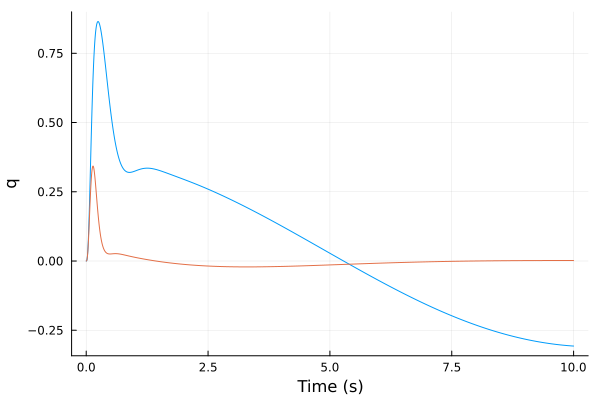

In [6]:
#build a gain matrix for the complete longitudinal dynamics and assign the
#components corresponding to the gain matrix computed from the reduced pitch
#dynamics
K_pitch_full = fill!(lss_lon.u0 * lss_lon.x0', 0)
K_pitch_full[:elevator_cmd, x_labels_pitch] = K_pitch
A_pitch_full_sas = lss_lon.A - lss_lon.B * K_pitch_full;

#add pitch regulation to the full longitudinal dynamics
nss_lon_sas = named_ss(ss(A_pitch_full_sas, lss_lon.B, lss_lon.C, 0), u = [:sas_pitch_cmd, :throttle_cmd], x = nss_lon.x, y = nss_lon.y);

dampreport(nss_pitch)
dampreport(nss_lon_sas)
e2q = nss_lon[:q, :elevator_cmd]
e2q_sas = nss_lon_sas[:q, :sas_pitch_cmd]
e2θ = nss_lon[:θ, :elevator_cmd]
e2θ_sas = nss_lon_sas[:θ, :sas_pitch_cmd]
step(e2q, 10) |> plot
step(e2q_sas, 10) |> plot!

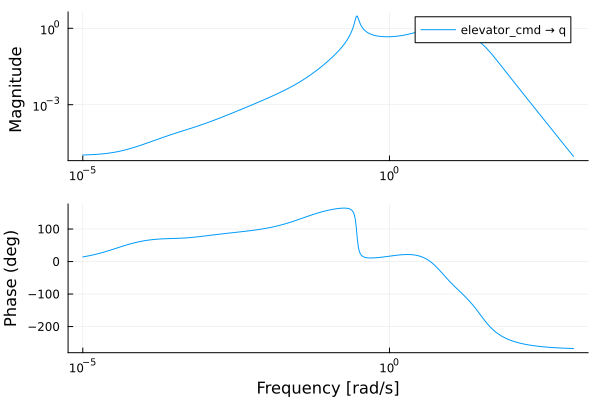

In [7]:
bodeplot(e2q)

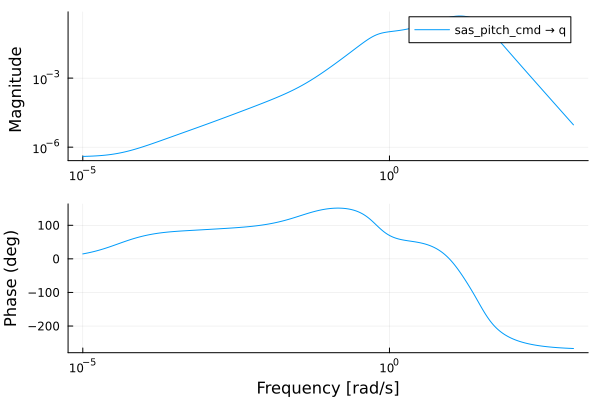

In [8]:
bodeplot(e2q_sas)

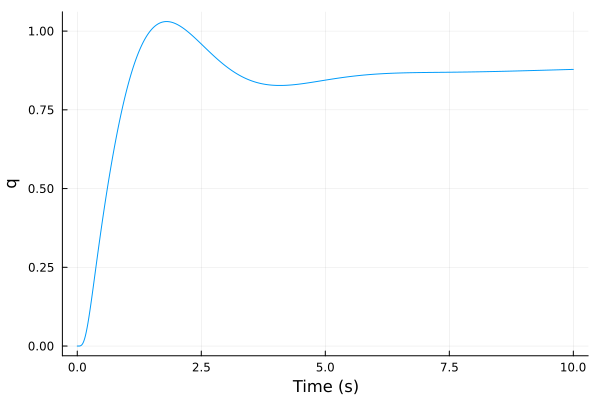

In [9]:

P_e2q = e2q_sas
C_q2e = named_ss(ss(20 * tf(1, [1, 0, 0])), :C_q2e; u = :q_err, y = :sas_pitch_cmd);
L_q2e = series(C_q2e, P_e2q)
T_q2e = output_comp_sensitivity(P_e2q, C_q2e)
# CS_q2e = G_CS(P_e2q, C_q2e)

marginplot(L_q2e)
# marginplot(CS_q2e)
step(T_q2e, 10) |> plot